## SMS SPAM FILTER FRAMEWORK | MACHINE LEARNING | TEXT ANALYTICS

--------------------------------------------------------------------------------------------------------------------------------

**Sumitted by**

D22010 - Aswin Kumar I S

D22024 - Laxmi Panchal 

D22027 - Maheshkumar N

**Problem Statement**: Developing an SMS Spam Filter using Natural Language Processing and Machine Learning Algorithms

The SMS Spam Collection v.1 (hereafter the corpus) is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam. 
This corpus has been collected from free or free for research sources at the Web:

A collection of between 425 SMS spam messages extracted manually from the Grumbletext Web site. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. The Grumbletext Web site is: http://www.grumbletext.co.uk/

A list of 450 SMS ham messages collected from Caroline Tag's PhD Theses available at http://etheses.bham.ac.uk/253/1/Tagg09PhD.pdf

A subset of 3,375 SMS ham messages of the NUS SMS Corpus (NSC), which is a corpus of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The NUS SMS Corpus is avalaible at: http://www.comp.nus.edu.sg/~rpnlpir/downloads/corpora/smsCorpus/

The amount of 1,002 SMS ham messages and 322 spam messages extracted from the SMS Spam Corpus v.0.1 Big created by José María Gómez Hidalgo and public available at: http://www.esp.uem.es/jmgomez/smsspamcorpus/


In [1]:
#import required Libraries
import pandas as pd
import string
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

### 1) READING THE DATA

In [2]:
# Loading and reading the dataset
doc = pd.read_csv(r'C:\Users\aswin\Downloads\smsspamcollection\SMSSpamCollection.csv',header=None)
doc.columns = ['Labels','SMS']

In [3]:
# Checking for the target class imbalance
doc.Labels.value_counts()

ham     4827
spam     747
Name: Labels, dtype: int64

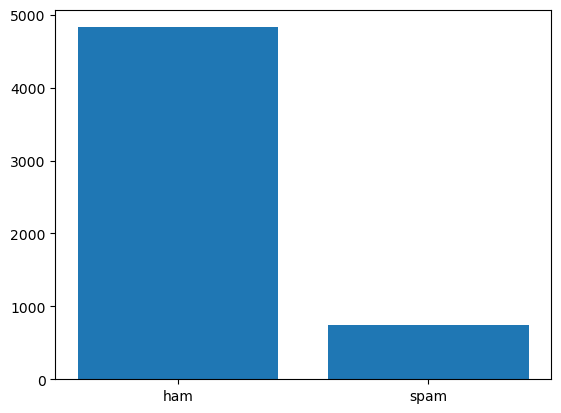

In [4]:
plt.bar(x= doc.Labels.unique(),height=doc.Labels.value_counts())
plt.show()

We observe that the target class is highly imbalanced (inclined towards ham) in the dataset.

### 2) TEXT PRE-PROCESSING

#### i) REMOVING EXTRA WHITESPACES BETWEEN WORDS

In [5]:
for i in range(len(doc.SMS)):
    doc.SMS[i] = doc.SMS[i].replace("  ", " ").strip()
doc.head()

,Labels,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


To avoid the confusion of extra white spaces being considered as a character we removed the extra whitespaces.

#### ii) REMOVING THE STOPWORDS FROM THE MESSAGES

In [6]:
# importing stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
for i in range(len(doc.SMS)):
    doc.SMS[i] = " ".join([w for w in doc.SMS[i].split() if w not in stop_words])

In [7]:
doc.head()

,Labels,SMS
0,ham,"Go jurong point, crazy.. Available bugis n gre..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say early hor... U c already say...
4,ham,"Nah I think goes usf, lives around though"


We've removed the stopwords since they don't make any add value or meaning to analysing whether spam or not spam.

#### iii) REMOVING REDUNDANCY OF WORDS USING LEMMATIZATION

In [8]:
# importing wordnet and omw
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aswin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aswin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [9]:
# import wordnetLemmatizer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
for i in range(len(doc.SMS)):
    words = nltk.word_tokenize(doc.SMS[i])
    doc.SMS[i] = " ".join([lemmatizer.lemmatize(word, pos='v') for word in words])

Why not stemming? Stemming chops off the word irrespective of the context, whereas the latter is context-dependent.

In [10]:
#Data Frame after Text Cleaning
doc.shape

(5574, 2)

In [11]:
# Taking a copy of the documents
engineered = doc.copy()

### 3) DATA EXPLORATION

#### USING WORD CLOUD MODEL

In [12]:
ham=""
spam=""

for i in range(doc.shape[0]):
    if doc.Labels[i] =='ham':
        ham=ham+doc.SMS[i]
    else:
        spam=spam+doc.SMS[i]

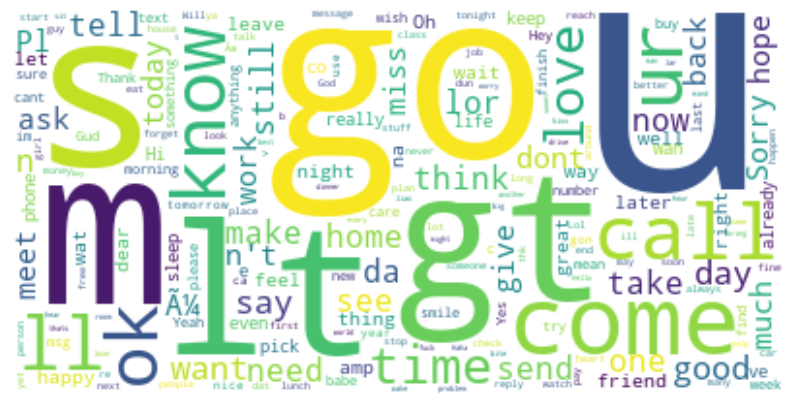

In [13]:
#Wordcloud for positive tweets
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(ham)
plt.figure(figsize=(10,12))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

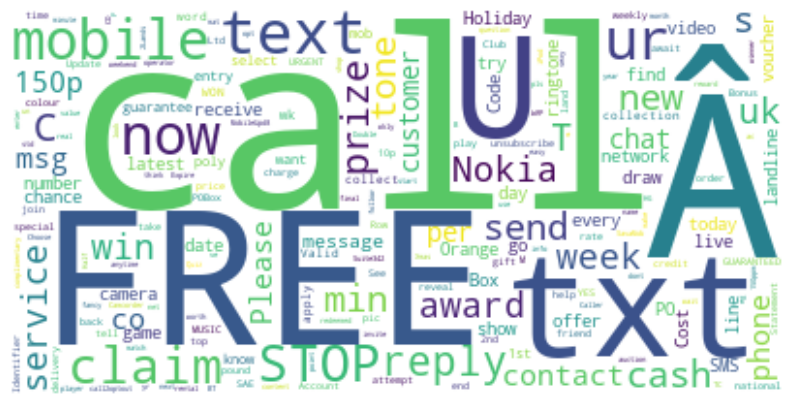

In [14]:
#Wordcloud for positive tweets
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(spam)
plt.figure(figsize=(10,12))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Observation : 

> We observe that call, come, time and think,etc are the most frequently occuring words in the ham messages.

> We observe that call, free,txtu,etc are the most frquently occuring words in spam messages.


#### Frequency value counts of all the unique words

In [15]:
value_counts_ham = {}
for i in ham.split():
    if i not in value_counts_ham:
        value_counts_ham[i]=1
    else:
        value_counts_ham[i]+=1

value_counts_spam = {}        
for j in spam.split():
    if j not in value_counts_spam:
        value_counts_spam[j]=1
    else:
        value_counts_spam[j]+=1        

We created 2 dictionaries to take into account of the frequency of all the unique words in ham and spam messages. This was done so that this can be used to engineer new features.

### 4) VECTORIZATION

#### a) VECTORIZATION USING TERM FREQUENCY MATRIX

In [16]:
#using count vectorizer to create a document-term matrix
cv=CountVectorizer()

# Training and transforming the data to an array
X=cv.fit_transform(doc.SMS).toarray()

# Extracting the words 
names=cv.get_feature_names()

#Converting the document-term matrix to a dataframe
tf_df=pd.DataFrame(X,columns=names)
tf_df

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,zoe,zogtorius,zoom,zouk,zyada,ãº1,ã¼,ãœ,éˆ,œharry
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5572,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### b) VECTORIZATION USING  TERM FREQUENCY-INVERSE DOCUMENT MATRIX

In [17]:
# Importing the TfidVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiating the TfidVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Training and transforming the data 
tfidf_vectors = tfidf_vectorizer.fit_transform(doc.SMS)

# Getting the name of the words
names = tfidf_vectorizer.get_feature_names()

# Creting an array of the vectors
tfidf_vectors = tfidf_vectors.toarray()

# Creating the tfidf dataframe
tfidf_df = pd.DataFrame(tfidf_vectors, columns=names)
tfidf_df

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,zoe,zogtorius,zoom,zouk,zyada,ãº1,ã¼,ãœ,éˆ,œharry
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.356249,0.0,0.0,0.0
5571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
5572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


#### c) VECTORIZATION USING GOOGLE'S WORD-TO-VEC MODEL

Here each document is represented as a vector of size 300.

In [18]:
# import keyedvectors from gensim library
from gensim.models import KeyedVectors

# Loading the embeddings
embeddings = KeyedVectors.load_word2vec_format(r'C:\Users\aswin\Downloads\./GoogleNews-vectors-negative300.bin', binary = True)

# Defining a function that return the vectorized equivalent of the word
def vec(a):
    return(embeddings[a])

# Converting each document into a vector
word_embeddings_list = {}

# Converting each document to a vector of length 300 (document to vector)
for doc1 in doc.SMS:
    vec_list = []
    for word in doc1.split():
        if word in embeddings.index_to_key:
            vec_list.append(vec(word))
    word_embeddings_list[doc1] = np.sum(np.array(vec_list),axis=0)

In [19]:
# Creating a dataframe with each row corresponds to an SMS 
doc2vec_df = pd.DataFrame.transpose(pd.DataFrame(word_embeddings_list))

#### d) GENERATE HEURISTIC FEATURES

#### Phone Number

In [20]:
import re
engineered["Phone Number Check"] = np.nan

In [21]:
# Creating a binary variable which describes the presence of phone number
for i in range(len(engineered)):
    phone_num = re.findall(r'\d{11}', engineered.iloc[i,1])
    if len(phone_num)>0:
        engineered.iloc[i,2] = 1
    else:
        engineered.iloc[i,2] = 0

In [22]:
engineered["Phone Number Check"] = engineered["Phone Number Check"].astype(int)

In [23]:
engineered["Phone Number Check"].value_counts()

0    5173
1     401
Name: Phone Number Check, dtype: int64

We've mapped spam with 1 and ham with 0 corresponding to the target variable.

#### $ Sign

In [24]:
# Creating a binary variable which describes the presence of '$' sign. We assume that most likely spam messages include a '$' sign in it

In [25]:
engineered["$ sign check"] = np.nan

In [26]:
for i in range(len(engineered)):
    sign = re.findall(r'\$', engineered.iloc[i,1])
    if len(sign)>0:
        engineered.iloc[i,3] = 1
    else:
        engineered.iloc[i,3] = 0

In [27]:
engineered["$ sign check"] = engineered["$ sign check"].astype(int)

In [28]:
engineered.head()

,Labels,SMS,Phone Number Check,$ sign check
0,ham,"Go jurong point , crazy .. Available bugis n g...",0,0
1,ham,Ok lar ... Joking wif u oni ...,0,0
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...,1,0
3,ham,U dun say early hor ... U c already say ...,0,0
4,ham,"Nah I think go usf , live around though",0,0


In [29]:
engineered["$ sign check"].value_counts()

0    5556
1      18
Name: $ sign check, dtype: int64

#### Capital letter word

Mostly spam messages occur with a combination of upper case words. We create a binary predictor which maps a particular document
to 1 if it has more than 3 upper-case words and 0 otherwise.

In [30]:
engineered["Capital letter word check"] = np.nan

In [31]:
pattern = r'\b[A-Z]+\b'
for i in range(len(engineered)):
    cap = len(re.findall(pattern, engineered.iloc[i,1]))
    if cap > 3:
        engineered.iloc[i,4] = 1 #spam
    else:
        engineered.iloc[i,4] = 0 #ham

In [32]:
engineered["Capital letter word check"] = engineered["Capital letter word check"].astype(int)

In [33]:
engineered

,Labels,SMS,Phone Number Check,$ sign check,Capital letter word check
0,ham,"Go jurong point , crazy .. Available bugis n g...",0,0,0
1,ham,Ok lar ... Joking wif u oni ...,0,0,0
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...,1,0,1
3,ham,U dun say early hor ... U c already say ...,0,0,0
4,ham,"Nah I think go usf , live around though",0,0,0
...,...,...,...,...,...
5569,spam,This 2nd time try 2 contact u. U Â£750 Pound p...,1,0,0
5570,ham,Will Ã¼ b go esplanade fr home ?,0,0,0
5571,ham,"Pity , * mood that . So ... any suggestions ?",0,0,0
5572,ham,The guy bitch I act like i 'd interest buy som...,0,0,0


In [34]:
engineered["Capital letter word check"].value_counts()

0    5165
1     409
Name: Capital letter word check, dtype: int64

#### Spelling_Mistake Check

Usually the spam messages come along with mispelt words. Hence we create a continuos variable as a predictor that measures the proportion of mispelled words in a document.

In [35]:
#! pip install spellchecker
#! pip install pyspellchecker

In [36]:
# Importing spell checker
from spellchecker import SpellChecker
spell = SpellChecker(language='en')

In [37]:
engineered["SpellingMistake%Check"] = np.nan

In [38]:
for i in range(len(engineered)):
    misspelled_words = spell.unknown(engineered.iloc[i,1].split())
    prop =  len(misspelled_words) / len(engineered.iloc[i,1].split())
    engineered.iloc[i,5] = prop

#### Proportion of Punctuations

Usually the spam messages come along with lot of punctuations. Hence we create a continuos variable as a predictor that measures the proportion of punctuations in a document.

In [39]:
engineered["Punctuation%Check"] = np.nan

In [40]:
for i in range(len(engineered)):
    punctuation = re.compile(r'[.,?!]')
    num_punctuation = len(punctuation.findall(engineered.iloc[i,1]))
    punct_prop = num_punctuation / len(engineered.iloc[i,1])
    engineered.iloc[i,6] = punct_prop

#### Subjectivity Score of Sentence

Creating a continuous feature based on the documents which measures the subjectivity score

> Subjectivity and fake messages can be related in that a subjective message is more likely to be considered as a fake message. A subjective message is one that is based on personal opinions, feelings, and beliefs, rather than facts or evidence. When a message lacks objectivity, it can be more easily manipulated or distorted to serve the interests of the sender, making it harder to distinguish between real and fake information.

In [41]:
#!pip install textblob

In [42]:
# Importing the TextBlob 
from textblob import TextBlob

In [43]:
engineered["Subjectivity Score"] = np.nan
#engineered.head()

In [44]:
for i in range(len(engineered)):
    blob = TextBlob(engineered.iloc[i,1])
    sub_score = blob.sentiment.subjectivity
    engineered.iloc[i,7] = sub_score

#### Sentiment Score using Vader

We're using vader library to measure the strength of sentiment. Exteme sentiments at either end are usually observed in spam messages.

In [45]:
#!pip install vaderSentiment

In [46]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [47]:
engineered["Sentiment Score"] = np.nan

In [48]:
for i in range(len(engineered)):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(engineered.iloc[i,1])
    sentiment_score = sentiment['compound']
    engineered.iloc[i,8] = sentiment_score

In [49]:
engineered.head()

,Labels,SMS,Phone Number Check,$ sign check,Capital letter word check,SpellingMistake%Check,Punctuation%Check,Subjectivity Score,Sentiment Score
0,ham,"Go jurong point , crazy .. Available bugis n g...",0,0,0,0.250000,0.094737,0.683333,0.4019
1,ham,Ok lar ... Joking wif u oni ...,0,0,0,0.125000,0.193548,0.500000,0.4767
2,spam,Free entry 2 wkly comp win FA Cup final tkts 2...,1,0,1,0.281250,0.006667,0.550000,0.7964
3,ham,U dun say early hor ... U c already say ...,0,0,0,0.181818,0.139535,0.300000,0.0000
4,ham,"Nah I think go usf , live around though",0,0,0,0.111111,0.025641,0.500000,-0.1027


###  5) PERFORMING DIMENSIONALITY REDUCTION

#### PRINCIPAL COMPONENT ANALYSIS

#### i)  PCA ON TERM FREQUENCY MATRIX

In [50]:
# Importing the PCA model, instantiating, training and transforming the data
from sklearn.decomposition import PCA
pca = PCA()
principalcomponents = pca.fit_transform(tf_df)

# Determining the cumulative percentage of the variance explained by the prinicpal components
cum_var_arr = np.cumsum((pca.explained_variance_*100) / np.sum(pca.explained_variance_))

# Determining the number of principal components that explains the 
count=0
for i in cum_var_arr:
    if i<=95:
        count+=1
    else:
        break
print('Number of principal components explaining 95% of the variance is:',count)

# Creating the dataframe with the principal components
principalDF = pd.DataFrame(data=principalcomponents)

# Subsetting the dataframe based on the selected no.of principal components
pca_tf_df = principalDF.iloc[:,:count]

Number of principal components explaining 95% of the variance is: 1796


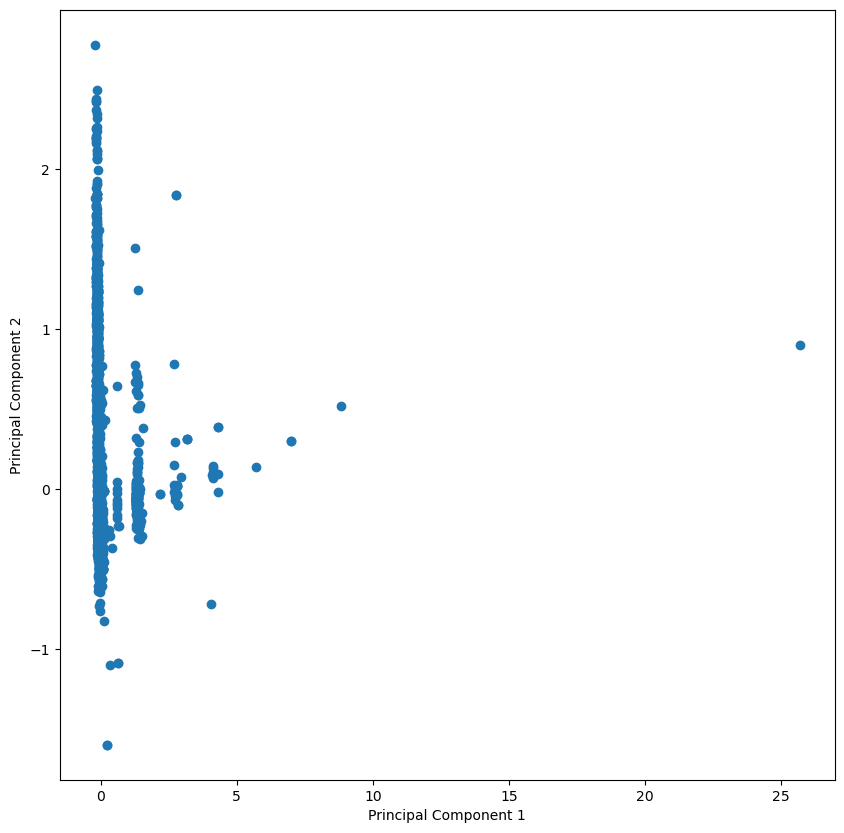

In [51]:
#Visualizing the words using PCs...(fancier version)

fig, ax = plt.subplots(figsize = (10,10)) # Create custom size image

   
ax.scatter(principalDF[0], principalDF[1]); # Plot a dot for each word
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')


# # Add the word label over each dot in the scatter plot
# for i in principalDF.index:
#     ax.annotate(i, (principalDF.loc[i, 'PC1'], principalDF.loc[i, 'PC2']))
    
    
# # Print an arrow for each word
# for i in principalDF.index:
#     ax.arrow(0, 0, principalDF.loc[i, 'PC1'], principalDF.loc[i, 'PC2'], head_width=0.005, head_length=0.005, fc='r', ec='r', width = 1e-5)

    
plt.show()

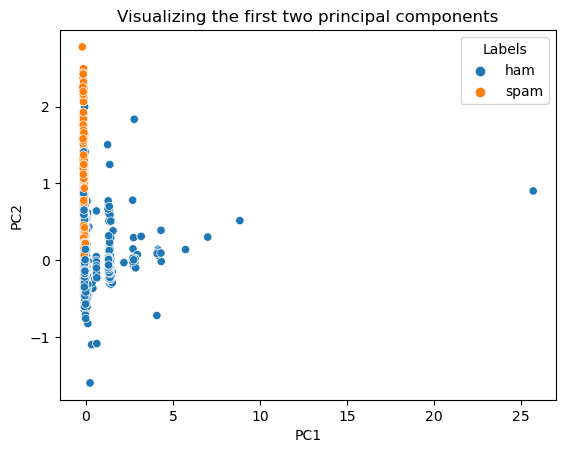

In [52]:
pca_tf_df = pd.concat([pca_tf_df,doc['Labels']],axis=1)
sns.scatterplot(x = pca_tf_df[0], y = pca_tf_df[1], data = pca_tf_df, hue = pca_tf_df["Labels"])
plt.title('Visualizing the first two principal components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#### ii) Performing PCA on TF-IDF MATRIX

In [221]:
# Importing the PCA model, instantiating, training and transforming the data
from sklearn.decomposition import PCA
pca = PCA()
principalcomponents = pca.fit_transform(tfidf_df)

# Determining the cumulative percentage of the variance explained by the prinicpal components
cum_var_arr = np.cumsum((pca.explained_variance_*100) / np.sum(pca.explained_variance_))

# Determining the number of principal components that explains the 
count=0
for i in cum_var_arr:
    if i<=95:
        count+=1
    else:
        break
print('Number of principal components explaining 95% of the variance is:',count)

# Creating the dataframe with the principal components
principalDF = pd.DataFrame(data=principalcomponents)

# Subsetting the dataframe based on the selected no.of principal components
pca_tf_idf = principalDF.iloc[:,:count]

Number of principal components explaining 95% of the variance is: 2591


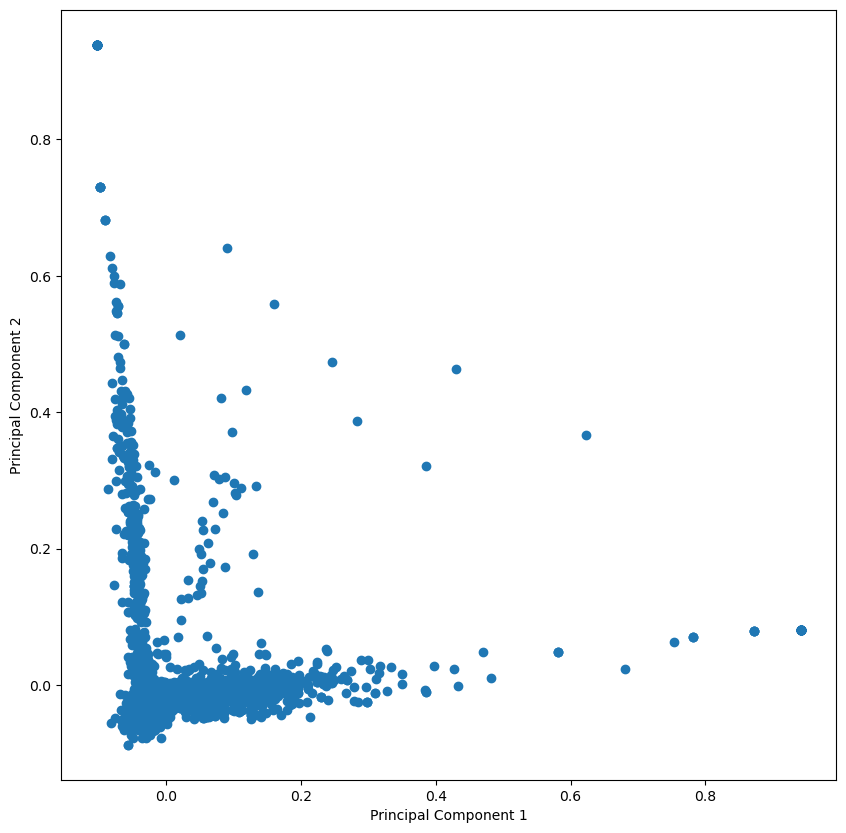

In [222]:
#Visualizing the words using PCs...(fancier version)

fig, ax = plt.subplots(figsize = (10,10)) # Create custom size image

   
ax.scatter(principalDF[0], principalDF[1]); # Plot a dot for each word
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')


# # Add the word label over each dot in the scatter plot
# for i in principalDF.index:
#     ax.annotate(i, (principalDF.loc[i, 'PC1'], principalDF.loc[i, 'PC2']))
    
    
# # Print an arrow for each word
# for i in principalDF.index:
#     ax.arrow(0, 0, principalDF.loc[i, 'PC1'], principalDF.loc[i, 'PC2'], head_width=0.005, head_length=0.005, fc='r', ec='r', width = 1e-5)

    
plt.show()

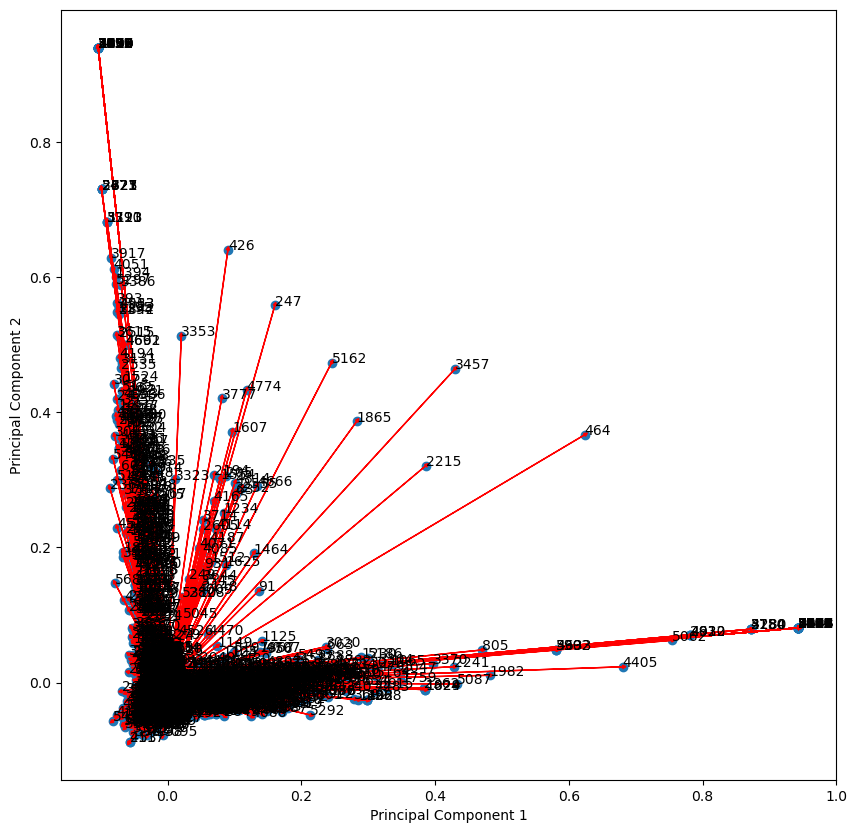

In [223]:
#Visualizing the words using PCs...(fancier version)

fig, ax = plt.subplots(figsize = (10, 10)) # Create custom size image

   
ax.scatter(principalDF[0], principalDF[1]); # Plot a dot for each word
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')


# Add the word label over each dot in the scatter plot
for i in principalDF.index:
    ax.annotate(i, (principalDF.loc[i, 0], principalDF.loc[i, 1]))
    
    
# Print an arrow for each word
for i in principalDF.index:
    ax.arrow(0, 0, principalDF.loc[i, 0], principalDF.loc[i, 1], head_width=0.005, head_length=0.005, fc='r', ec='r', width = 1e-5)

    
plt.show()

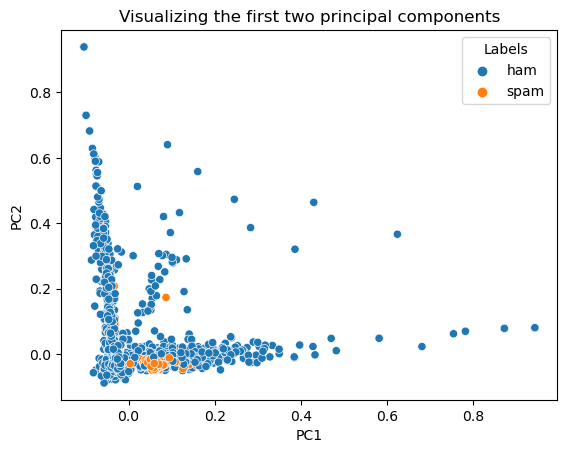

In [224]:
pca_tf_idf = pd.concat([pca_tf_idf,doc['Labels']],axis=1)
sns.scatterplot(x = pca_tf_idf[0], y = pca_tf_idf[1], data = pca_tf_idf, hue = pca_tf_idf["Labels"])
plt.title('Visualizing the first two principal components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [225]:
tfidf_df1 = tfidf_df.copy()
#Remove terms that is contained in less than 1% of the documents
for col in list(tfidf_df):
    prop=tfidf_df[col].sum()/tfidf_df.shape[0]
    if prop*100 <1:
        tfidf_df1 = tfidf_df1.drop([col],axis=1)

#### iii) Performing PCA on DOC2VEC MATRIX

In [226]:
# # Importing the PCA model, instantiating, training and transforming the data
from sklearn.decomposition import PCA
pca = PCA()
principalcomponents = pca.fit_transform(doc2vec_df)

# Determining the cumulative percentage of the variance explained by the prinicpal components
cum_var_arr = np.cumsum((pca.explained_variance_*100) / np.sum(pca.explained_variance_))

# Determining the number of principal components that explains the 
count=0
for i in cum_var_arr:
    if i<=95:
        count+=1
    else:
        break
print('Number of principal components explaining 95% of the variance is:',count)

# Creating the dataframe with the principal components
principalDF = pd.DataFrame(data=principalcomponents,index=doc2vec_df.index)

# Subsetting the dataframe based on the selected no.of principal components
pca_doc2vec_df = principalDF.iloc[:,:count]

Number of principal components explaining 95% of the variance is: 180


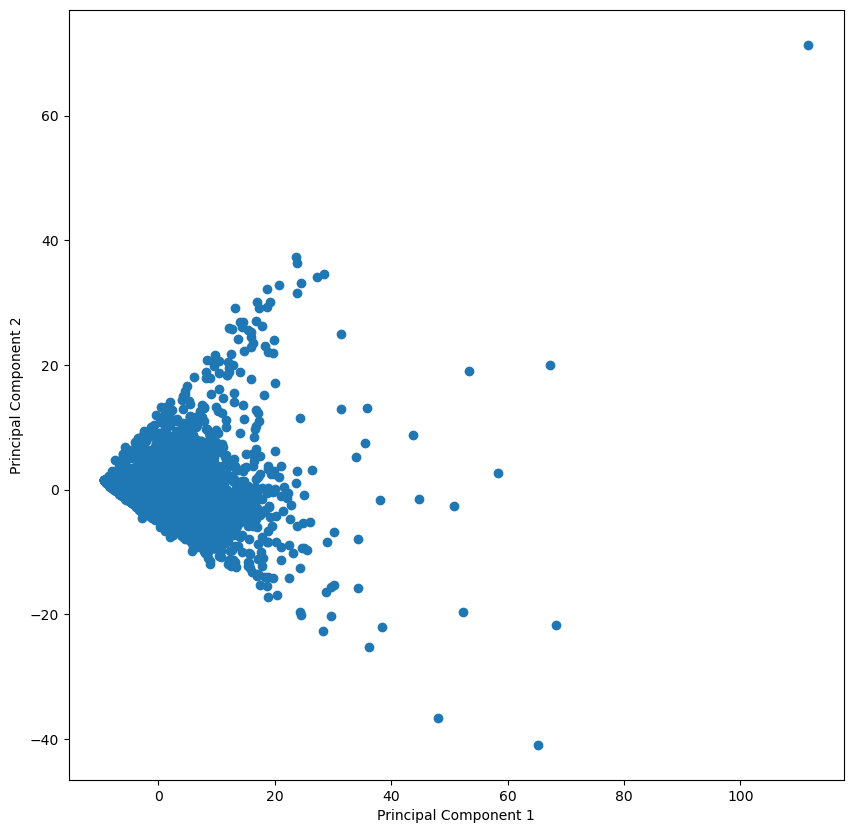

In [227]:
#Visualizing the words using PCs...(fancier version)

fig, ax = plt.subplots(figsize = (10,10)) # Create custom size image

   
ax.scatter(principalDF[0], principalDF[1]); # Plot a dot for each word
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')


# # Add the word label over each dot in the scatter plot
# for i in principalDF.index:
#     ax.annotate(i, (principalDF.loc[i, 'PC1'], principalDF.loc[i, 'PC2']))
    
    
# # Print an arrow for each word
# for i in principalDF.index:
#     ax.arrow(0, 0, principalDF.loc[i, 'PC1'], principalDF.loc[i, 'PC2'], head_width=0.005, head_length=0.005, fc='r', ec='r', width = 1e-5)

    
plt.show()

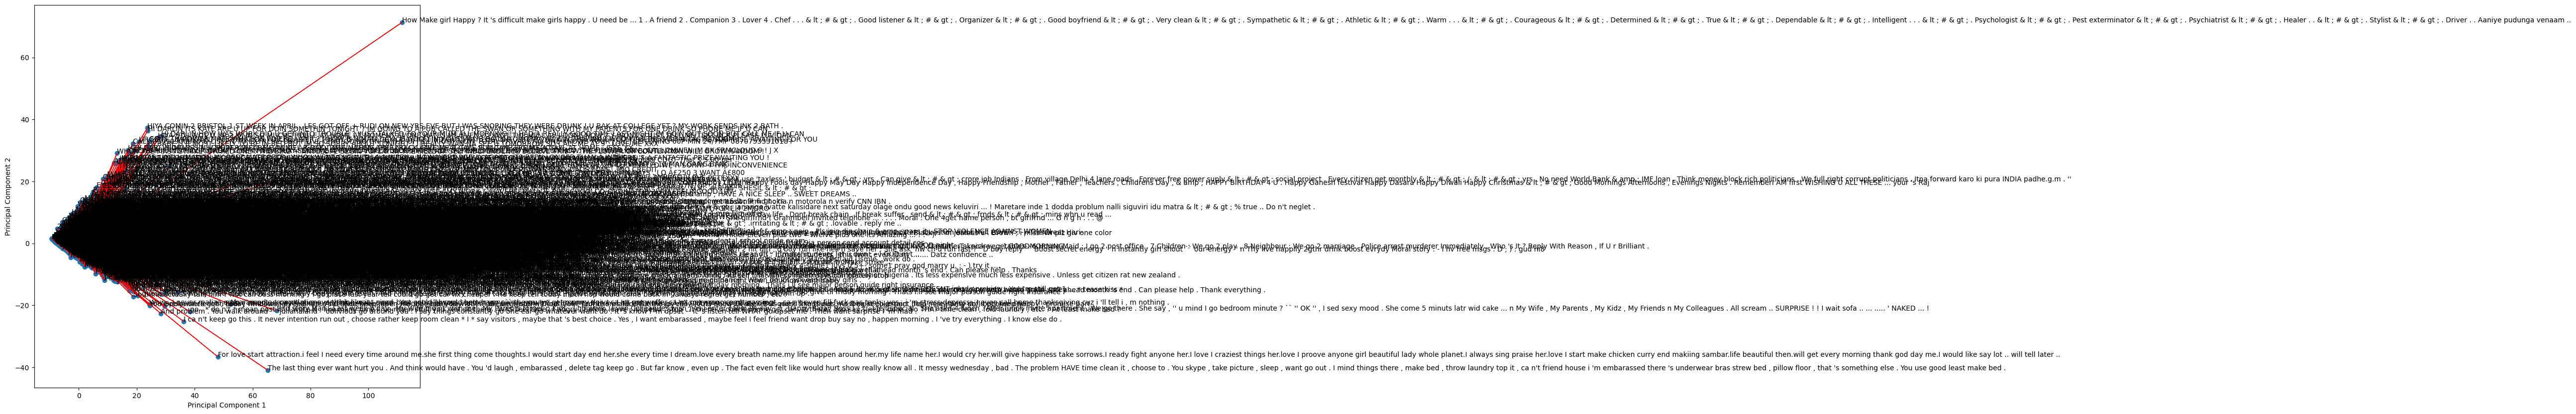

In [228]:
#Visualizing the words using PCs...(fancier version)

fig, ax = plt.subplots(figsize = (10, 10)) # Create custom size image

   
ax.scatter(principalDF[0], principalDF[1]); # Plot a dot for each word
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')


# Add the word label over each dot in the scatter plot
for i in principalDF.index:
    ax.annotate(i, (principalDF.loc[i, 0], principalDF.loc[i, 1]))
    
    
# Print an arrow for each word
for i in principalDF.index:
    ax.arrow(0, 0, principalDF.loc[i, 0], principalDF.loc[i, 1], head_width=0.005, head_length=0.005, fc='r', ec='r', width = 1e-5)

    
plt.show()

In [229]:
# Resetting the index of the dataframe
pca_doc2vec_df.reset_index(inplace=True)

# Creating the label column and filling it will null values
pca_doc2vec_df['label'] = np.nan

# Mapping the label column from the original dataframe with the corresponding document in embeddings document
for i in range(len(doc.SMS)): 
    for j in range(len(pca_doc2vec_df['index'])):
        if doc['SMS'][i]==pca_doc2vec_df['index'][j]:
            pca_doc2vec_df.iloc[j,181]=doc.Labels[j]

# Converting the label column into binary classes
pca_doc2vec_df['label'].replace({'ham':0,'spam':1},inplace=True)

In [230]:
pca_doc2vec_df['label'].replace({0:'ham',1:'spam'},inplace=True)

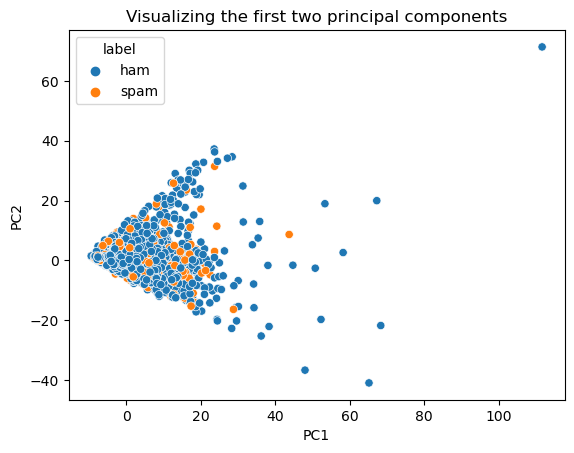

In [231]:
sns.scatterplot(x = pca_doc2vec_df[0], y = pca_doc2vec_df[1], data = pca_doc2vec_df, hue = pca_doc2vec_df["label"])
plt.title('Visualizing the first two principal components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#### iv) HEURISTIC APPROACH p% TO THE DOCUMENT TERM FREQUENCY MATRIX

In [232]:
# Creating a copy of the tf_df matrix
tf_df1 = tf_df.copy()

In [233]:
#Remove terms that is contained in less than 1% of the documents
for col in list(tf_df):
    prop=tf_df[col].sum()/tf_df.shape[0]
    if prop*100 <1:
        tf_df1=tf_df1.drop([col],axis=1)

In [234]:
tf_df1.shape

(5574, 200)

#### v) HEURISTIC APPROACH p% TO THE DOCUMENT TERM FREQUENCY INVERSE DOCUMENT TERM FREQUENCY MATRIX

In [235]:
# Creating a copy of the term-frequency inverse document frequency matrix
tfidf_df1 = tfidf_df.copy()
#Remove terms that is contained in less than 1% of the documents
for col in list(tfidf_df):
    prop=tfidf_df[col].sum()/tfidf_df.shape[0]
    if prop*100 <1:
        tfidf_df1 = tfidf_df1.drop([col],axis=1)

In [236]:
tfidf_df1.shape

(5574, 15)

#### vi) PERFORMING PCA ON HEURISTIC MATRIX

In [237]:
engineered

,Labels,SMS,Phone Number Check,$ sign check,Capital letter word check,SpellingMistake%Check,Punctuation%Check,Subjectivity Score,Sentiment Score
0,0,"Go jurong point , crazy .. Available bugis n g...",0,0,0,0.250000,0.094737,0.683333,0.4019
1,0,Ok lar ... Joking wif u oni ...,0,0,0,0.125000,0.193548,0.500000,0.4767
2,1,Free entry 2 wkly comp win FA Cup final tkts 2...,1,0,1,0.281250,0.006667,0.550000,0.7964
3,0,U dun say early hor ... U c already say ...,0,0,0,0.181818,0.139535,0.300000,0.0000
4,0,"Nah I think go usf , live around though",0,0,0,0.111111,0.025641,0.500000,-0.1027
...,...,...,...,...,...,...,...,...,...
5569,1,This 2nd time try 2 contact u. U Â£750 Pound p...,1,0,0,0.222222,0.045113,0.611111,0.7574
5570,0,Will Ã¼ b go esplanade fr home ?,0,0,0,0.375000,0.031250,0.000000,0.0000
5571,0,"Pity , * mood that . So ... any suggestions ?",0,0,0,0.090909,0.133333,0.200000,-0.2960
5572,0,The guy bitch I act like i 'd interest buy som...,0,0,0,0.058824,0.000000,0.400000,0.6124


In [238]:
# # Importing the PCA model, instantiating, training and transforming the data
from sklearn.decomposition import PCA
pca = PCA()
principalcomponents = pca.fit_transform(engineered.iloc[:,2:])

# Determining the cumulative percentage of the variance explained by the prinicpal components
cum_var_arr = np.cumsum((pca.explained_variance_*100) / np.sum(pca.explained_variance_))

# Determining the number of principal components that explains the 
count=0
for i in cum_var_arr:
    if i<=95:
        count+=1
    else:
        break
print('Number of principal components explaining 95% of the variance is:',count)

# Creating the dataframe with the principal components
principalDF = pd.DataFrame(data=principalcomponents,index=engineered.index)

# Subsetting the dataframe based on the selected no.of principal components
pca_heuristic_df = principalDF.iloc[:,:count]

Number of principal components explaining 95% of the variance is: 3


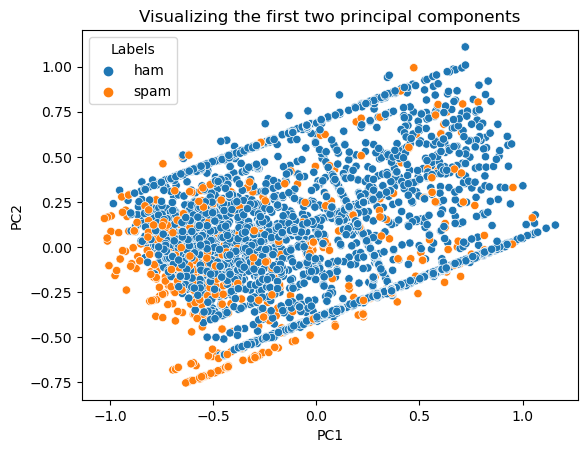

In [239]:
pca_heuristic_df = pd.concat([pca_heuristic_df,doc['Labels']],axis=1)
sns.scatterplot(x = pca_heuristic_df[0], y = pca_heuristic_df[1], data = pca_heuristic_df, hue = pca_heuristic_df["Labels"])
plt.title('Visualizing the first two principal components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [240]:
pca_heuristic_df

,0,1,2,Labels
0,-0.275524,0.219518,-0.129510,ham
1,-0.267578,0.028556,-0.149257,ham
2,-0.800290,-0.136443,1.201202,spam
3,0.242165,0.035139,-0.062739,ham
4,0.251606,0.260185,-0.052238,ham
...,...,...,...,...
5569,-0.702750,-0.124762,0.462071,spam
5570,0.365208,-0.243286,-0.041086,ham
5571,0.548429,0.066018,-0.018979,ham
5572,-0.349673,-0.112126,-0.169839,ham


### 6. SPAM FILTERS

### a) MODEL BUILDING FRAMEWORK

#### TRAIN VALIDATION TEST SPLIT

In [241]:
y = doc.Labels.map({'ham':0,'spam':1})

In [242]:
y1 = y.copy()

#### ESTIMATING MODEL PERFORMANCE ON TERM FREQUENCY MATRIX

In [243]:
#For train-test split
from sklearn.model_selection import train_test_split   #import train_test_split function

X_train, X_test, y_train, y_test = train_test_split(tf_df, y, test_size = 0.20)  # X-predictors, y-target

#Train-Validation Split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.20)

In [244]:
#import libraries for Model fittings
import sklearn.ensemble as ensemble #import ensemble for bagging
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,recall_score,f1_score,precision_score #import Scoring metric
from sklearn.ensemble import RandomForestClassifier #import randomforest Classifier
from sklearn.ensemble import AdaBoostClassifier #import adaboostclassifer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

#### Logistic Regression

In [245]:
#Training the model 
lr = LogisticRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_valid)
#y_pred #predictions done by decision tree

In [246]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[763   1]
 [ 16 112]]


In [247]:
lr = pd.DataFrame({'Logistic Regression': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
lr

,Logistic Regression
Accuracy,0.980942
F1_score,0.929461
Recall,0.875000
Precision,0.991150


#### Decision Tree Model

In [248]:
#Training the model with best hyperparameters
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train,y_train)
pred = dt.predict(X_valid)
#y_pred #predictions done by decision tree

In [249]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[730  34]
 [ 32  96]]


In [250]:
db1 = pd.DataFrame({'Decision Tree': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Decision Tree
Accuracy,0.926009
F1_score,0.744186
Recall,0.750000
Precision,0.738462


#### Bagged Decision Tree Model

In [251]:
dt = DecisionTreeClassifier()      #decision tree model as base classifier for bagging -ensemble

baggedModel = ensemble.BaggingClassifier(base_estimator=dt) #bagging with DT models

baggedModel.fit(X_train,y_train) #fitting training data in bagged model
pred = baggedModel.predict(X_valid)

In [252]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[762   2]
 [ 21 107]]


In [253]:
db1 = pd.DataFrame({'Bagged Decision Tree': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Bagged Decision Tree
Accuracy,0.974215
F1_score,0.902954
Recall,0.835938
Precision,0.981651


#### Random Forest Model

In [254]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)        # fitting training data in random forest model

pred= rf.predict(X_valid)

In [255]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[764   0]
 [ 25 103]]


In [256]:
db1 = pd.DataFrame({'Random Forest': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Random Forest
Accuracy,0.971973
F1_score,0.891775
Recall,0.804688
Precision,1.000000


#### Adaboost Model

In [257]:
ada_boost = AdaBoostClassifier()
ada_boost.fit(X_train, y_train) # fitting training data in adaboost model

pred = ada_boost.predict(X_valid)

In [258]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[764   0]
 [ 22 106]]


In [259]:
db1 = pd.DataFrame({'AdaBoost Tree': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,AdaBoost Tree
Accuracy,0.975336
F1_score,0.905983
Recall,0.828125
Precision,1.000000


#### ESTIMATING MODEL PERFORMANCE ON TERM FREQUENCY MATRIX OBTAINED AFTER DIMENSIONALITY REDUCTION - PCA

In [260]:
pca_tf_df1 = pca_tf_df.drop(columns=['Labels'])

In [261]:
#For train-test split
from sklearn.model_selection import train_test_split   #import train_test_split function

X_train, X_test, y_train, y_test = train_test_split(pca_tf_df1, y, test_size = 0.20)  # X-predictors, y-target

#Train-Validation Split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.20)

#### Logistic Regression

In [262]:
#Training the model 
lr = LogisticRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_valid)
#y_pred #predictions done by decision tree

In [263]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[771   1]
 [ 19 101]]


In [264]:
lr = pd.DataFrame({'Logistic Regression': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
lr

,Logistic Regression
Accuracy,0.977578
F1_score,0.909910
Recall,0.841667
Precision,0.990196


#### Decision Tree Model

In [265]:
#Training the model with best hyperparameters
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train,y_train)
pred = dt.predict(X_valid)
#y_pred #predictions done by decision tree

In [266]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[748  24]
 [ 20 100]]


In [267]:
db1 = pd.DataFrame({'Decision Tree': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Decision Tree
Accuracy,0.950673
F1_score,0.819672
Recall,0.833333
Precision,0.806452


#### Bagged Decision Tree Model

In [268]:
dt = DecisionTreeClassifier()      #decision tree model as base classifier for bagging -ensemble

baggedModel = ensemble.BaggingClassifier(base_estimator=dt) #bagging with DT models

baggedModel.fit(X_train,y_train) #fitting training data in bagged model
pred = baggedModel.predict(X_valid)

In [269]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[765   7]
 [ 23  97]]


In [270]:
db1 = pd.DataFrame({'Bagged Decision Tree': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Bagged Decision Tree
Accuracy,0.966368
F1_score,0.866071
Recall,0.808333
Precision,0.932692


#### Random Forest Model

In [271]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)        # fitting training data in random forest model

pred= rf.predict(X_valid)

In [272]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[772   0]
 [ 52  68]]


In [273]:
db1 = pd.DataFrame({'Random Forest': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Random Forest
Accuracy,0.941704
F1_score,0.723404
Recall,0.566667
Precision,1.000000


#### Adaboost Model

In [274]:
ada_boost = AdaBoostClassifier()
ada_boost.fit(X_train, y_train) # fitting training data in adaboost model

pred = ada_boost.predict(X_valid) 

In [275]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[764   8]
 [ 17 103]]


In [276]:
db1 = pd.DataFrame({'AdaBoost': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,AdaBoost
Accuracy,0.971973
F1_score,0.891775
Recall,0.858333
Precision,0.927928


#### ESTIMATING MODEL PERFORMANCE ON TERM FREQUENCY - INVERSE DOCUMENT FREQUENCY MATRIX

In [277]:
#For train-test split
from sklearn.model_selection import train_test_split   #import train_test_split function

X_train, X_test, y_train, y_test = train_test_split(tfidf_df, y, test_size = 0.20)  # X-predictors, y-target

#Train-Validation Split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.20)

#### Logistic Regression

In [278]:
#Training the model 
lr = LogisticRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_valid)
#y_pred #predictions done by decision tree

In [279]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[777   0]
 [ 43  72]]


In [280]:
lr = pd.DataFrame({'Logistic Regression': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
lr

,Logistic Regression
Accuracy,0.951794
F1_score,0.770053
Recall,0.626087
Precision,1.000000


#### Decision Tree Model

In [281]:
#Training the model with best hyperparameters
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
pred = dt.predict(X_valid)
#y_pred #predictions done by decision tree

In [282]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[765  12]
 [ 17  98]]


In [283]:
db1 = pd.DataFrame({'Decision Tree': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Decision Tree
Accuracy,0.967489
F1_score,0.871111
Recall,0.852174
Precision,0.890909


#### Bagged Decision Tree Model

In [284]:
dt = DecisionTreeClassifier()      #decision tree model as base classifier for bagging -ensemble

baggedModel = ensemble.BaggingClassifier(base_estimator=dt) #bagging with DT models

baggedModel.fit(X_train,y_train) #fitting training data in bagged model
pred_bg = baggedModel.predict(X_valid)

In [285]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[765  12]
 [ 17  98]]


In [286]:
db1 = pd.DataFrame({'Bagged Decision Tree': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Bagged Decision Tree
Accuracy,0.967489
F1_score,0.871111
Recall,0.852174
Precision,0.890909


#### Random Forest Model

In [287]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)        # fitting training data in random forest model

pred= rf.predict(X_valid)

In [288]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[777   0]
 [ 20  95]]


In [289]:
db1 = pd.DataFrame({'Random Forest': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Random Forest
Accuracy,0.977578
F1_score,0.904762
Recall,0.826087
Precision,1.000000


#### Adaboost Model

In [290]:
ada_boost = AdaBoostClassifier()
ada_boost.fit(X_train, y_train) # fitting training data in adaboost model

pred = ada_boost.predict(X_valid)

In [291]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[771   6]
 [ 19  96]]


In [292]:
db1 = pd.DataFrame({'AdaBoost': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,AdaBoost
Accuracy,0.971973
F1_score,0.884793
Recall,0.834783
Precision,0.941176


#### ESTIMATING MODEL PERFORMANCE ON TFIDF MATRIX OBTAINED AFTER DIMENSIONALITY REDUCTION - PCA

In [293]:
pca_tf_idf1 = pca_tf_idf.drop(columns=['Labels'])

In [294]:
#For train-test split
from sklearn.model_selection import train_test_split   #import train_test_split function

X_train, X_test, y_train, y_test = train_test_split(pca_tf_idf1, y, test_size = 0.20)  # X-predictors, y-target

#Train-Validation Split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.20)

#### Logistic Regression

In [295]:
#Training the model 
lr = LogisticRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_valid)
#y_pred #predictions done by decision tree

In [296]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[771   1]
 [ 46  74]]


In [297]:
lr = pd.DataFrame({'Logistic Regression': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
lr

,Logistic Regression
Accuracy,0.947309
F1_score,0.758974
Recall,0.616667
Precision,0.986667


#### Decision Tree Model

In [298]:
#Training the model with best hyperparameters
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train,y_train)
pred = dt.predict(X_valid)
#y_pred #predictions done by decision tree

In [299]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[755  17]
 [ 22  98]]


In [300]:
db1 = pd.DataFrame({'Decision Tree': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Decision Tree
Accuracy,0.956278
F1_score,0.834043
Recall,0.816667
Precision,0.852174


#### Bagged Decision Tree Model

In [301]:
dt = DecisionTreeClassifier()      #decision tree model as base classifier for bagging -ensemble

baggedModel = ensemble.BaggingClassifier(base_estimator=dt) #bagging with DT models

baggedModel.fit(X_train,y_train) #fitting training data in bagged model
pred = baggedModel.predict(X_valid)

In [302]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[767   5]
 [ 32  88]]


In [303]:
db1 = pd.DataFrame({'Bagged Decision Tree': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Bagged Decision Tree
Accuracy,0.958520
F1_score,0.826291
Recall,0.733333
Precision,0.946237


#### Random Forest Model

In [304]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)        # fitting training data in random forest model

pred= rf.predict(X_valid)

In [305]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[772   0]
 [ 62  58]]


In [306]:
db1 = pd.DataFrame({'Random Forest': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Random Forest
Accuracy,0.930493
F1_score,0.651685
Recall,0.483333
Precision,1.000000


#### Adaboost Model

In [307]:
ada_boost = AdaBoostClassifier()
ada_boost.fit(X_train, y_train) # fitting training data in adaboost model

pred = ada_boost.predict(X_valid)

In [308]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

db1 = pd.DataFrame({'AdaBoost': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

[[766   6]
 [ 20 100]]


,AdaBoost
Accuracy,0.970852
F1_score,0.884956
Recall,0.833333
Precision,0.943396


#### ESTIMATING MODEL PERFORMANCE ON DOC2VEC MODEL

In [309]:
# Resetting the index of the dataframe
doc2vec_df = doc2vec_df.reset_index()

# Creating the label column and filling it will null values
doc2vec_df['label'] = np.nan

# Mapping the label column from the original dataframe with the corresponding document in embeddings document
for i in range(len(doc.SMS)): 
    for j in range(len(doc2vec_df['index'])):
        if doc['SMS'][i]==doc2vec_df['index'][j]:
            doc2vec_df.iloc[j,301]=doc.Labels[j]

# Converting the label column into binary classes
doc2vec_df['label'].replace({'ham':0,'spam':1},inplace=True)

#### ESTIMATING MODEL PERFORMANCE ON DOC2VEC MATRIX

In [310]:
doc2vec_df.set_index('index',inplace=True)

In [311]:
y = doc2vec_df['label']

In [312]:
X = doc2vec_df.drop(columns='label')

In [313]:
#For train-test split
from sklearn.model_selection import train_test_split   #import train_test_split function

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)  # X-predictors, y-target

#Train-Validation Split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.20)

#### Logistic Regression

In [314]:
#Training the model 
lr = LogisticRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_valid)
#y_pred #predictions done by decision tree

In [315]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[702  11]
 [110   2]]


In [316]:
lr = pd.DataFrame({'Logistic Regression': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
lr

,Logistic Regression
Accuracy,0.853333
F1_score,0.032000
Recall,0.017857
Precision,0.153846


#### Decision Tree Model

In [317]:
#Training the model with best hyperparameters
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
pred = dt.predict(X_valid)
#y_pred #predictions done by decision tree

In [318]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

db1 = pd.DataFrame({'Decision Tree': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

[[591 122]
 [ 94  18]]


,Decision Tree
Accuracy,0.738182
F1_score,0.142857
Recall,0.160714
Precision,0.128571


#### Bagged Decision Tree Model

In [319]:
dt = DecisionTreeClassifier()      #decision tree model as base classifier for bagging -ensemble

baggedModel = ensemble.BaggingClassifier(base_estimator=dt) #bagging with DT models

baggedModel.fit(X_train,y_train) #fitting training data in bagged model
pred = baggedModel.predict(X_valid)

In [320]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

db1 = pd.DataFrame({'Bagged Decision Tree': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

[[706   7]
 [109   3]]


,Bagged Decision Tree
Accuracy,0.859394
F1_score,0.049180
Recall,0.026786
Precision,0.300000


#### Random Forest Model

In [321]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)        # fitting training data in random forest model

pred= rf.predict(X_valid)

In [322]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

db1 = pd.DataFrame({'Random Forest': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

[[712   1]
 [112   0]]


,Random Forest
Accuracy,0.86303
F1_score,0.00000
Recall,0.00000
Precision,0.00000


#### Adaboost Model

In [323]:
ada_boost = AdaBoostClassifier()
ada_boost.fit(X_train, y_train) # fitting training data in adaboost model
pred = ada_boost.predict(X_valid) 

In [324]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

db1 = pd.DataFrame({'AdaBoost': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

[[704   9]
 [110   2]]


,AdaBoost
Accuracy,0.855758
F1_score,0.032520
Recall,0.017857
Precision,0.181818


#### ESTIMATING MODEL PERFORMANCE ON WORD2VEC MATRIX AFTER DIMENSIONALITY REDUCTION USING PCA

In [325]:
# Dropping the label column
pca_doc2vec_df1 = pca_doc2vec_df.drop(columns=['label'])

# Converting the SMS into the index of the dataframe
pca_doc2vec_df1.set_index('index',inplace=True)

In [326]:
#For train-test split
from sklearn.model_selection import train_test_split   #import train_test_split function

X_train, X_test, y_train, y_test = train_test_split(pca_doc2vec_df1, y, test_size = 0.20)  # X-predictors, y-target

#Train-Validation Split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.20)

#### Logistic Regression

In [327]:
#Training the model 
lr = LogisticRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_valid)
#y_pred #predictions done by decision tree

In [328]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[707   0]
 [  0 118]]


In [329]:
lr = pd.DataFrame({'Logistic Regression': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
lr

,Logistic Regression
Accuracy,1.0
F1_score,1.0
Recall,1.0
Precision,1.0


#### Decision Tree Model

In [330]:
#Training the model with best hyperparameters
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train,y_train)
pred = dt.predict(X_valid)
#y_pred #predictions done by decision tree

In [331]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

db1 = pd.DataFrame({'Decision Tree': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

[[684  23]
 [ 64  54]]


,Decision Tree
Accuracy,0.894545
F1_score,0.553846
Recall,0.457627
Precision,0.701299


#### Bagged Decision Tree Model

In [332]:
dt = DecisionTreeClassifier()      #decision tree model as base classifier for bagging -ensemble

baggedModel = ensemble.BaggingClassifier(base_estimator=dt) #bagging with DT models

baggedModel.fit(X_train,y_train) #fitting training data in bagged model
pred = baggedModel.predict(X_valid)

In [333]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

db1 = pd.DataFrame({'Bagging Decision': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

[[703   4]
 [ 62  56]]


,Bagging Decision
Accuracy,0.920000
F1_score,0.629213
Recall,0.474576
Precision,0.933333


#### Random Forest Model

In [334]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)        # fitting training data in random forest model

pred = rf.predict(X_valid)

In [335]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

db1 = pd.DataFrame({'Random Forest': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

[[707   0]
 [103  15]]


,Random Forest
Accuracy,0.875152
F1_score,0.225564
Recall,0.127119
Precision,1.000000


#### Adaboost Model

In [336]:
ada_boost = AdaBoostClassifier()
ada_boost.fit(X_train, y_train) # fitting training data in adaboost model

pred = ada_boost.predict(X_valid) 

In [337]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

db1 = pd.DataFrame({'AdaBoost': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

[[701   6]
 [ 21  97]]


,AdaBoost
Accuracy,0.967273
F1_score,0.877828
Recall,0.822034
Precision,0.941748


#### EVALUATING THE PERFORMANCE OF THE "P%" MODEL USED ON TERM FREQUENCY MATRIX

In [338]:
#For train-test split
from sklearn.model_selection import train_test_split   #import train_test_split function

X_train, X_test, y_train, y_test = train_test_split(tf_df1, y1, test_size = 0.20)  # X-predictors, y-target

#Train-Validation Split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.20)

#### Logistic Regression

In [339]:
#Training the model 
lr = LogisticRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_valid)
#y_pred #predictions done by decision tree

In [340]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[775   1]
 [ 13 103]]


In [341]:
lr = pd.DataFrame({'Logistic Regression': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
lr

,Logistic Regression
Accuracy,0.984305
F1_score,0.936364
Recall,0.887931
Precision,0.990385


#### Decision Tree Model

In [342]:
#Training the model with best hyperparameters
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train,y_train)
pred = dt.predict(X_valid)
#y_pred #predictions done by decision tree

In [343]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[773   3]
 [ 53  63]]


In [344]:
db1 = pd.DataFrame({'Decision Tree': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Decision Tree
Accuracy,0.937220
F1_score,0.692308
Recall,0.543103
Precision,0.954545


#### Bagged Decision Tree Model

In [345]:
dt = DecisionTreeClassifier()      #decision tree model as base classifier for bagging -ensemble

baggedModel = ensemble.BaggingClassifier(base_estimator=dt) #bagging with DT models

baggedModel.fit(X_train,y_train) #fitting training data in bagged model
pred = baggedModel.predict(X_valid)

In [346]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[758  18]
 [ 16 100]]


In [347]:
db1 = pd.DataFrame({'Bagged Decision Tree': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Bagged Decision Tree
Accuracy,0.961883
F1_score,0.854701
Recall,0.862069
Precision,0.847458


#### Random Forest Model

In [348]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)        # fitting training data in random forest model

pred= rf.predict(X_valid)

In [349]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[765  11]
 [ 12 104]]


In [350]:
db1 = pd.DataFrame({'Random Forest': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Random Forest
Accuracy,0.974215
F1_score,0.900433
Recall,0.896552
Precision,0.904348


#### Adaboost Model

In [351]:
ada_boost = AdaBoostClassifier()
ada_boost.fit(X_train, y_train) # fitting training data in adaboost model

pred = ada_boost.predict(X_valid) 

In [352]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[773   3]
 [ 15 101]]


In [353]:
db1 = pd.DataFrame({'AdaBoost': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,AdaBoost
Accuracy,0.979821
F1_score,0.918182
Recall,0.870690
Precision,0.971154


#### EVALUATING THE PERFORMANCE OF THE "P%" MODEL USED ON TERM FREQUENCY INVERSE TERM FREQUENCY MATRIX

In [354]:
#For train-test split
from sklearn.model_selection import train_test_split   #import train_test_split function

X_train, X_test, y_train, y_test = train_test_split(tfidf_df1, y1, test_size = 0.20)  # X-predictors, y-target

#Train-Validation Split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.20)

#### Logistic Regression

In [355]:
#Training the model 
lr = LogisticRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_valid)
#y_pred #predictions done by decision tree

In [356]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[767   4]
 [121   0]]


In [357]:
lr = pd.DataFrame({'Logistic Regression': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
lr

,Logistic Regression
Accuracy,0.859865
F1_score,0.000000
Recall,0.000000
Precision,0.000000


#### Decision Tree Model

In [358]:
#Training the model with best hyperparameters
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train,y_train)
pred = dt.predict(X_valid)
#y_pred #predictions done by decision tree

In [359]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[741  30]
 [ 45  76]]


In [360]:
db1 = pd.DataFrame({'Decision Tree': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Decision Tree
Accuracy,0.915919
F1_score,0.669604
Recall,0.628099
Precision,0.716981


#### Bagged Decision Tree Model

In [361]:
dt = DecisionTreeClassifier()      #decision tree model as base classifier for bagging -ensemble

baggedModel = ensemble.BaggingClassifier(base_estimator=dt) #bagging with DT models

baggedModel.fit(X_train,y_train) #fitting training data in bagged model
pred = baggedModel.predict(X_valid)

In [362]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[751  20]
 [ 40  81]]


In [363]:
db1 = pd.DataFrame({'Bagging Decision Tree': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Bagging Decision Tree
Accuracy,0.932735
F1_score,0.729730
Recall,0.669421
Precision,0.801980


#### Random Forest Model

In [364]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)        # fitting training data in random forest model

pred= rf.predict(X_valid)

In [365]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[750  21]
 [ 38  83]]


In [366]:
db1 = pd.DataFrame({'Random Forest': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Random Forest
Accuracy,0.933857
F1_score,0.737778
Recall,0.685950
Precision,0.798077


#### Adaboost Model

In [367]:
ada_boost = AdaBoostClassifier()
ada_boost.fit(X_train, y_train) # fitting training data in adaboost model

pred = ada_boost.predict(X_valid) 

In [368]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[745  26]
 [ 50  71]]


In [369]:
db1 = pd.DataFrame({'AdaBoost': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,AdaBoost
Accuracy,0.914798
F1_score,0.651376
Recall,0.586777
Precision,0.731959


#### EVALUATING THE PERFORMANCE OF THE  MODEL USED ON GENERATED HEURISTIC FEATURES DATA-MATRIX

In [370]:
#Mapping 1 and 0 to 'spam' and 'ham'

In [371]:
engineered['Labels'].replace({'spam':1,'ham':0},inplace=True)

In [372]:
X_eng=engineered.drop(["Labels","SMS"],axis=1)
y_eng = engineered["Labels"]

In [373]:
#For train-test split
from sklearn.model_selection import train_test_split   #import train_test_split function

X_train, X_test, y_train, y_test = train_test_split(X_eng, y_eng, test_size = 0.20)  # X-predictors, y-target

#Train-Validation Split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.20)

#### Logistic Regression

In [374]:
#Training the model 
lr = LogisticRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_valid)
#y_pred #predictions done by decision tree

In [375]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[777   0]
 [ 39  76]]


In [376]:
lr = pd.DataFrame({'Logistic Regression': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
lr

,Logistic Regression
Accuracy,0.956278
F1_score,0.795812
Recall,0.660870
Precision,1.000000


#### Decision Tree Model

In [377]:
#Training the model with best hyperparameters
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train,y_train)
pred = dt.predict(X_valid)
#y_pred #predictions done by decision tree

In [378]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[763  14]
 [ 29  86]]


In [379]:
db1 = pd.DataFrame({'Decision Tree': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Decision Tree
Accuracy,0.951794
F1_score,0.800000
Recall,0.747826
Precision,0.860000


#### Bagged Decision Tree Model

In [380]:
dt = DecisionTreeClassifier()      #decision tree model as base classifier for bagging -ensemble

baggedModel = ensemble.BaggingClassifier(base_estimator=dt) #bagging with DT models

baggedModel.fit(X_train,y_train) #fitting training data in bagged model
pred = baggedModel.predict(X_valid)

In [381]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[766  11]
 [ 24  91]]


In [382]:
db1 = pd.DataFrame({'Bagging Decision Tree': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Bagging Decision Tree
Accuracy,0.960762
F1_score,0.838710
Recall,0.791304
Precision,0.892157


#### Random Forest Model

In [383]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)        # fitting training data in random forest model

pred= rf.predict(X_valid)

In [384]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[769   8]
 [ 24  91]]


In [385]:
db1 = pd.DataFrame({'Random Forest': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,Random Forest
Accuracy,0.964126
F1_score,0.850467
Recall,0.791304
Precision,0.919192


#### Adaboost Model

In [386]:
ada_boost = AdaBoostClassifier()
ada_boost.fit(X_train, y_train) # fitting training data in adaboost model

pred = ada_boost.predict(X_valid) 

In [387]:
#Metrics
Accuracy = accuracy_score(y_valid,pred)
F1_score = f1_score(y_valid,pred)
Recall_score = recall_score(y_valid,pred)
Precision = precision_score(y_valid,pred)
print(confusion_matrix(y_valid,pred))

[[765  12]
 [ 31  84]]


In [388]:
db1 = pd.DataFrame({'AdaBoost': [Accuracy,F1_score,Recall_score,Precision]}, 
                                index=['Accuracy','F1_score','Recall','Precision'])
db1

,AdaBoost
Accuracy,0.951794
F1_score,0.796209
Recall,0.730435
Precision,0.875000


# CONCLUSION:

> We observed the performance of different models with 4 different vectorization techniques and along with dimensionality reduction. 

> The performance of the machine learning models with term-frequency matrix method performed better than all other models corresponding to different vectorization techniques.

> The performance of the models fitted with words2vec method gives the worst performance on different machine learning models.

> The machine learning models fitted with heurestic features were observed to perform better than word2vec model and comparitively similar term frequency and inverse document term frequency vectorized mthods.

> We observe that there is a great oppurtunity to develop more heuristic features which classifies the target accurately and are relatively easier to interpret than other vectorization methods.

> Based on F-1 scores, logistic regression and random forest classifier performed better on different vectorization methods.